# House Prices Initial Exploration

I have switched to a second notebook since the first got really messy

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

## Read Data

In [2]:
df_train = pd.read_csv('../data/raw/train.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Some settings

In [4]:
# change number of rows/columns we will view
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

## Going Log

Since the goal is to predict the log of sales price, let's convert that right away

In [5]:
df_train['LogSalePrice']= np.log(df_train['SalePrice'])

# Find the NaN

Fix NaN values early

Dataset is clean so this is fairly easy

In [6]:
# Find columns containing NaN values
columns_with_nan = df_train.columns[df_train.isna().any()].tolist()

# Print the columns with NaN values
print("Columns with NaN values:", columns_with_nan)
print('                   ')
print('that is ' + str(len(columns_with_nan)) + ' columns')

# Count NaN values in each column
nan_counts = df_train.isna().sum()

# Print the counts of NaN values in each column
print("NaN Value Counts in Each Column:")
print(nan_counts)

Columns with NaN values: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
                   
that is 19 columns
NaN Value Counts in Each Column:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
LogSalePrice       0
Length: 82, dtype: int64


In [7]:
for column in columns_with_nan:
    print(df_train[column].value_counts())

LotFrontage
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: count, Length: 110, dtype: int64
Alley
Grvl    50
Pave    41
Name: count, dtype: int64
MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64
MasVnrArea
0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: count, Length: 327, dtype: int64
BsmtQual
TA    649
Gd    618
Ex    121
Fa     35
Name: count, dtype: int64
BsmtCond
TA    1311
Gd      65
Fa      45
Po       2
Name: count, dtype: int64
BsmtExposure
No    953
Av    221
Gd    134
Mn    114
Name: count, dtype: int64
BsmtFinType1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: count, dtype: int64
BsmtFinType2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: count, dtype: int64
Electrical
SBrkr    1334
Fus

In [8]:
df_train['GarageArea'].value_counts()

GarageArea
0      81
440    49
576    47
240    38
484    34
       ..
320     1
594     1
831     1
878     1
192     1
Name: count, Length: 441, dtype: int64

In [9]:
# Several features seem really easily fillable
# Categoricals that seem to be NaN because that feature is not on property
# often are other columns that verify this assumption (such as area = 0)

easy_fix_cols = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',  'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Replace NaN values in the categorical column with 'noFeature'
replacement_value = 'noFeature'
for col in easy_fix_cols:
    df_train[col] = df_train[col].fillna(replacement_value)

In [10]:
# MasVnrArea has some weird missing values

# Find the indices of NaN entries in the 'MasVnrArea' column
column_name = 'MasVnrArea'
nan_indices = df_train[df_train[column_name].isna()].index

# Print the values in the 'MasVnrType' column for the specified indices
column_name = 'MasVnrType'
values_for_indices = df_train.loc[nan_indices, column_name]
print("Values in the 'MasVnrType' column for the specified indices:")
print(values_for_indices)


Values in the 'MasVnrType' column for the specified indices:
234     noFeature
529     noFeature
650     noFeature
936     noFeature
973     noFeature
977     noFeature
1243    noFeature
1278    noFeature
Name: MasVnrType, dtype: object


From above, we see that all missing values of MasVnrArea are in houses with no masonry veneer.  So we can safely make them 0

In [11]:
# Set the values in the 'MasVnrArea' column for the specified indices to 0
column_name = 'MasVnrArea'
df_train.loc[nan_indices, column_name] = 0

In [12]:
# now check that the replacements worked

# Find columns containing NaN values
columns_with_nan = df_train.columns[df_train.isna().any()].tolist()

# Print the columns with NaN values
print("Columns with NaN values:", columns_with_nan)
print('                   ')
print('that is ' + str(len(columns_with_nan)) + ' columns')


Columns with NaN values: ['LotFrontage', 'Electrical', 'GarageYrBlt']
                   
that is 3 columns


## weirdest NaN

There are 3 remaining features with NaN values: LotFrontage, Electrical, and GarageYrBlt

Missing LotFrontage is either because lot has no connection to street, or measurement wasn't take.  We will assume the former and replace LotFrontage missing values with 0.

Will replace Electrical missing value (it's only one) with most common value

Will drop GarageYrBlt for now because idk what to replace that value with (it's where there is no garage); I think this should be okay because there is big correlation with Year built and the other garage variables

In [13]:
# meanLotFrontage = df_train['LotFrontage'].mean()
# df_train['LotFrontage'] = df_train['LotFrontage'].fillna(meanLotFrontage)
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(0)

most_common_value = df_train['Electrical'].value_counts().idxmax()
df_train['Electrical'] = df_train['Electrical'].fillna(most_common_value)


In [14]:
# now check that the replacements worked

# Find columns containing NaN values
columns_with_nan = df_train.columns[df_train.isna().any()].tolist()

# Print the columns with NaN values
print("Columns with NaN values:", columns_with_nan)
print('                   ')
print('that is ' + str(len(columns_with_nan)) + ' columns')

Columns with NaN values: ['GarageYrBlt']
                   
that is 1 columns


# Baseline Models

Begin by throwing everything at the model

## Convert Categorical to Dummy

In [15]:
# list of categorical and numerical variables
cat_cols = df_train.select_dtypes(include = ['object']).columns
num_cols = df_train.select_dtypes(include = ['int64', 'float64']).columns
print('there are ' + str(len(cat_cols)) + ' categorical variables')
print('there are ' + str(len(num_cols)) + ' numerical variables')

there are 43 categorical variables
there are 39 numerical variables


In [16]:
# Apply one-hot encoding to the categorical columns
df_encoded = pd.get_dummies(df_train, columns=cat_cols, drop_first=True)

Now we can train the model on all variables (except GarageYrBlt for now)

In [17]:
# features and response vars
# dropping GarageYrBlt because idk what to do with missing values
X = df_encoded.drop(columns = ['SalePrice', 'LogSalePrice', 'GarageYrBlt', 'Id'])
y = df_encoded['LogSalePrice']

In [18]:
df_encoded.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,...,False,False,False,True,False
1,2,20,80.0,9600,6,...,False,False,False,True,False
2,3,60,68.0,11250,7,...,False,False,False,True,False
3,4,70,60.0,9550,7,...,False,False,False,False,False
4,5,60,84.0,14260,8,...,False,False,False,True,False


## All Features

## Linear Model

In [29]:
# goal of project is measured in RMSE
# Define a custom RMSE scoring function
def rmse_scorer(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

In [24]:
# Create a LinearRegression model
model = LinearRegression()

# Create a 10-fold cross-validation object
kf = KFold(n_splits=10 , shuffle=True, random_state=42) # excluding some parameters

# Perform cross-validation
# scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(rmse_scorer, greater_is_better=False))
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Display the cross-validation results
print("Cross-Validation RMSE Scores:", scores)
print("Mean RMSE Score:", scores.mean())

Cross-Validation RMSE Scores: [-0.01573318 -0.06884912 -0.01225426 -0.03227351 -0.0733995  -0.02126471
 -0.05969498 -0.0286174  -0.01812929 -0.05999656]
Mean RMSE Score: -0.03902125104956101


In [25]:
X.shape

(1460, 258)

## CV Random Forest

In [29]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create a 10-fold cross-validation object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_scores = cross_val_score(rf_model, X, y, cv=kf, scoring=make_scorer(rmse_scorer, greater_is_better=False))

# Display the cross-validation results
print("Cross-Validation RMSE Scores:", cross_val_scores)
print("Mean RMSE Score:", np.mean(cross_val_scores))

Cross-Validation RMSE Scores: [-0.13736449 -0.16212022 -0.113248   -0.14067342 -0.17257835 -0.15974991
 -0.1697204  -0.12815163 -0.14345947 -0.0960964 ]
Mean RMSE Score: -0.14231622821773068


## Backward Stepping Feature Selection

## Linear Model Feature Selection

In [88]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
0,1,60,RL,65.0,8450,...,2008,WD,Normal,208500,12.247694
1,2,20,RL,80.0,9600,...,2007,WD,Normal,181500,12.109011
2,3,60,RL,68.0,11250,...,2008,WD,Normal,223500,12.317167
3,4,70,RL,60.0,9550,...,2006,WD,Abnorml,140000,11.849398
4,5,60,RL,84.0,14260,...,2008,WD,Normal,250000,12.429216
...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,...,2007,WD,Normal,175000,12.072541
1456,1457,20,RL,85.0,13175,...,2010,WD,Normal,210000,12.254863
1457,1458,70,RL,66.0,9042,...,2010,WD,Normal,266500,12.493130
1458,1459,20,RL,68.0,9717,...,2010,WD,Normal,142125,11.864462


In [41]:
min_features_to_select = 5  # Minimum number of features to consider
# model_type = LinearRegression()
model_type = RandomForestRegressor(random_state=42)
# model_type = Lasso(alpha = 0.05)

cv = KFold(n_splits = 10, shuffle = True, random_state = 42)

rfecv = RFECV(
    estimator=model_type,
    step=1,
    cv=cv,
    scoring=make_scorer(rmse_scorer, greater_is_better=False),
    min_features_to_select=min_features_to_select,
    n_jobs=1,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 23


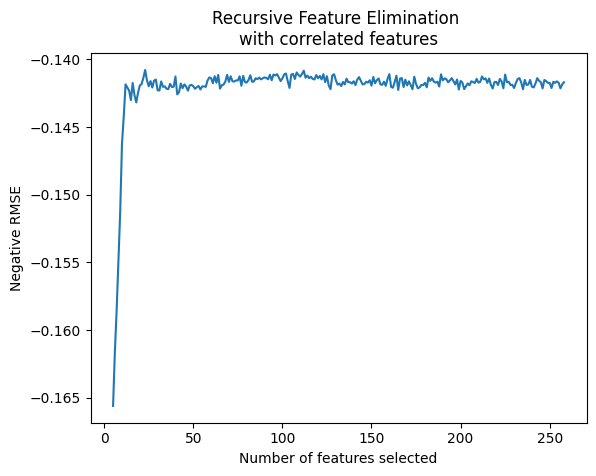

In [42]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Negative RMSE")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    #yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
# ax = plt.gca()
# ax.set_ylim([-10, 1])
plt.show()

In [43]:
rfecv.cv_results_["mean_test_score"]

array([-0.16560338, -0.16163015, -0.15853396, -0.15479485, -0.15126468,
       -0.14622849, -0.14419717, -0.14185194, -0.14208788, -0.14230925,
       -0.14301208, -0.14174956, -0.14264168, -0.14318387, -0.1424759 ,
       -0.14193466, -0.14182664, -0.1413694 , -0.14078377, -0.14154418,
       -0.14198861, -0.14160613, -0.14208442, -0.14157419, -0.14149654,
       -0.14229445, -0.14230051, -0.14163434, -0.14203071, -0.14200128,
       -0.14217429, -0.14219421, -0.14180872, -0.14204794, -0.14202489,
       -0.1412694 , -0.14258745, -0.14243043, -0.14178831, -0.14212936,
       -0.14185601, -0.14200807, -0.14231547, -0.14192899, -0.14188663,
       -0.14199062, -0.14217892, -0.14205405, -0.14196857, -0.14222724,
       -0.14200734, -0.1419972 , -0.14203571, -0.14156579, -0.14134049,
       -0.14139157, -0.1417698 , -0.14124809, -0.14172889, -0.14115213,
       -0.14216362, -0.1419136 , -0.14186818, -0.14163812, -0.14114404,
       -0.14166844, -0.14125227, -0.14162768, -0.14163805, -0.14